# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Нам необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Перед нами стоит задача регрессии. Для оценки качества модели будет использоваться `RMSE`

### Описание данных

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**:
- `Price` — цена (евро)

In [1]:
from tempfile import tempdir

# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from overrides.typing_utils import unknown

## Загрузка и проверка данных

Загрузим данные, посмотрим описание данных. Так же приведем столбцы к единому стилю

In [2]:
# Загрузка данных
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('data/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
# Выводим информацию о датасете
print(df.info())

# Выводим описание числовых столбцов
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
RegistrationYear,354369.0,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Power,354369.0,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Kilometer,354369.0,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,1067.0,30165.0,49413.0,71083.0,99998.0,25783.096248
LastSeen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


In [4]:
# Смотрим на количество уникальных значений в каждом столбце
df.nunique()

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Мы видим, что у нас 1 уникальное значение в столбце с количеством фотографий. Так же при описании данных видно, что там всего одно значение: 0. Это бесполезный для обучения модели, удалим его. Так же мы видим, что у нас 8000 уникальных значений в столбце с почтовым кодом. Это не числовой столбец, но для категориального там слишком много уникальных значений. Потенциально, это бесполезный для модели столбец, потому скорее всего нам придется удалить его. В столбце `Repaired` всего 2 уникальных значения, это булевый столбец. Перед тем, как привести его к корректному типу данных, необходимо будет заполнить пропуски. Сделаем это позже. Все остальные столбцы приведены к корректному типу данных

In [5]:
# Удаляем пустой столбец
df = df.drop('NumberOfPictures', axis=1)

# Выводим датафрейм
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,87439,2016-04-07 07:15:26


In [6]:
# Переименовываем столбцы
df = df.rename(columns={
    'DateCrawled': 'crawl_date',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'RegistrationMonth': 'registration_month',
    'Gearbox': 'gearbox_type',
    'Power': 'horsepower',
    'Brand': 'car_brand',
    'Model': 'car_model',
    'Kilometer': 'km_driven',
    'FuelType': 'fuel_type',
    'Repaired': 'is_repaired',
    'DateCreated': 'creation_date',
    'PostalCode': 'postal_code',
    'LastSeen': 'user_last_seen',
})

# Проверяем, корректно ли все переименовалось
df.columns

Index(['crawl_date', 'price', 'vehicle_type', 'registration_year',
       'gearbox_type', 'horsepower', 'car_model', 'km_driven',
       'registration_month', 'fuel_type', 'car_brand', 'is_repaired',
       'creation_date', 'postal_code', 'user_last_seen'],
      dtype='object')

### Вывод

Все столбцы приведены к корректному типу данных. Был удален бесполезный столбец с количеством фотографий: `NumberOfPictures`

Мы привели столбцы к единому и более удобному формату:
- `crawl_date` — дата скачивания анкеты из базы (ранее `DateCrawled`)
- `price` — цена автомобиля (ранее `Price`)
- `vehicle_type` — тип автомобильного кузова (ранее `VehicleType`)
- `registration_year` — год регистрации автомобиля (ранее `RegistrationYear`)
- `registration_month` — месяц регистрации автомобиля (ранее `RegistrationMonth`)
- `gearbox_type` — тип коробки передач (ранее `Gearbox`)
- `horsepower` — мощность автомобиля в лошадиных силах (ранее `Power`)
- `car_brand` — марка автомобиля (ранее `Brand`)
- `car_model` — модель автомобиля (ранее `Model`)
- `km_driven` — пробег автомобиля в километрах (ранее `Kilometer`)
- `fuel_type` — тип топлива (ранее `FuelType`)
- `is_repaired` — флаг, указывающий, была ли машина в ремонте (ранее `Repaired`)
- `creation_date` — дата создания анкеты (ранее `DateCreated`)
- `postal_code` — почтовый индекс владельца автомобиля (ранее `PostalCode`)
- `user_last_seen` — дата последней активности пользователя (ранее `LastSeen`)


## Предобработка данных

Предобработаем данные: заполним пропуски, проверим датасет на наличие явных и неявных дубликатов, а так же вычленим год, месяц, и день из дат

Для начала выделим год, месяц и день из дат. Так как оригинальные столбцы содержат еще и время, то просто удалим их за ненадобностью.

In [7]:
# Выделяем для даты скачивания из базы данных
df['crawl_year'] = df['crawl_date'].dt.year
df['crawl_month'] = df['crawl_date'].dt.month
df['crawl_day'] = df['crawl_date'].dt.day

# Выделяем для даты создания анкеты
df['creation_year'] = df['creation_date'].dt.year
df['creation_month'] = df['creation_date'].dt.month
df['creation_day'] = df['creation_date'].dt.day

# Выделяем для даты последней активности пользователя
df['user_last_seen_year'] = df['user_last_seen'].dt.year
df['user_last_seen_month'] = df['user_last_seen'].dt.month
df['user_last_seen_day'] = df['user_last_seen'].dt.day

# Удаляем оригинальные столбцы за ненужностью
df = df.drop(['crawl_date', 'creation_date', 'user_last_seen'], axis=1)

# Выводим столбец
df

,price,vehicle_type,registration_year,gearbox_type,horsepower,car_model,km_driven,registration_month,fuel_type,car_brand,...,postal_code,crawl_year,crawl_month,crawl_day,creation_year,creation_month,creation_day,user_last_seen_year,user_last_seen_month,user_last_seen_day
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,...,70435,2016,3,24,2016,3,24,2016,4,7
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,66954,2016,3,24,2016,3,24,2016,4,7
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,90480,2016,3,14,2016,3,14,2016,4,5
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,91074,2016,3,17,2016,3,17,2016,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,60437,2016,3,31,2016,3,31,2016,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,...,2694,2016,3,21,2016,3,21,2016,3,21
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,...,39576,2016,3,14,2016,3,14,2016,4,6
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,26135,2016,3,5,2016,3,5,2016,3,11
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,87439,2016,3,19,2016,3,19,2016,4,7


/Users/moncervers/PycharmProjects/car_price_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable crawl_year for analysis 1. Dropping this column
  warnings.warn(
/Users/moncervers/PycharmProjects/car_price_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable user_last_seen_year for analysis 1. Dropping this column
  warnings.warn(
/Users/moncervers/PycharmProjects/car_price_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable crawl_year for analysis 1. Dropping this column
  warnings.warn(
/Users/moncervers/PycharmProjects/car_price_prediction/.venv/lib/python3.12/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable user_last_seen_year for analysis 1. Dropping this column
  warnings.warn(


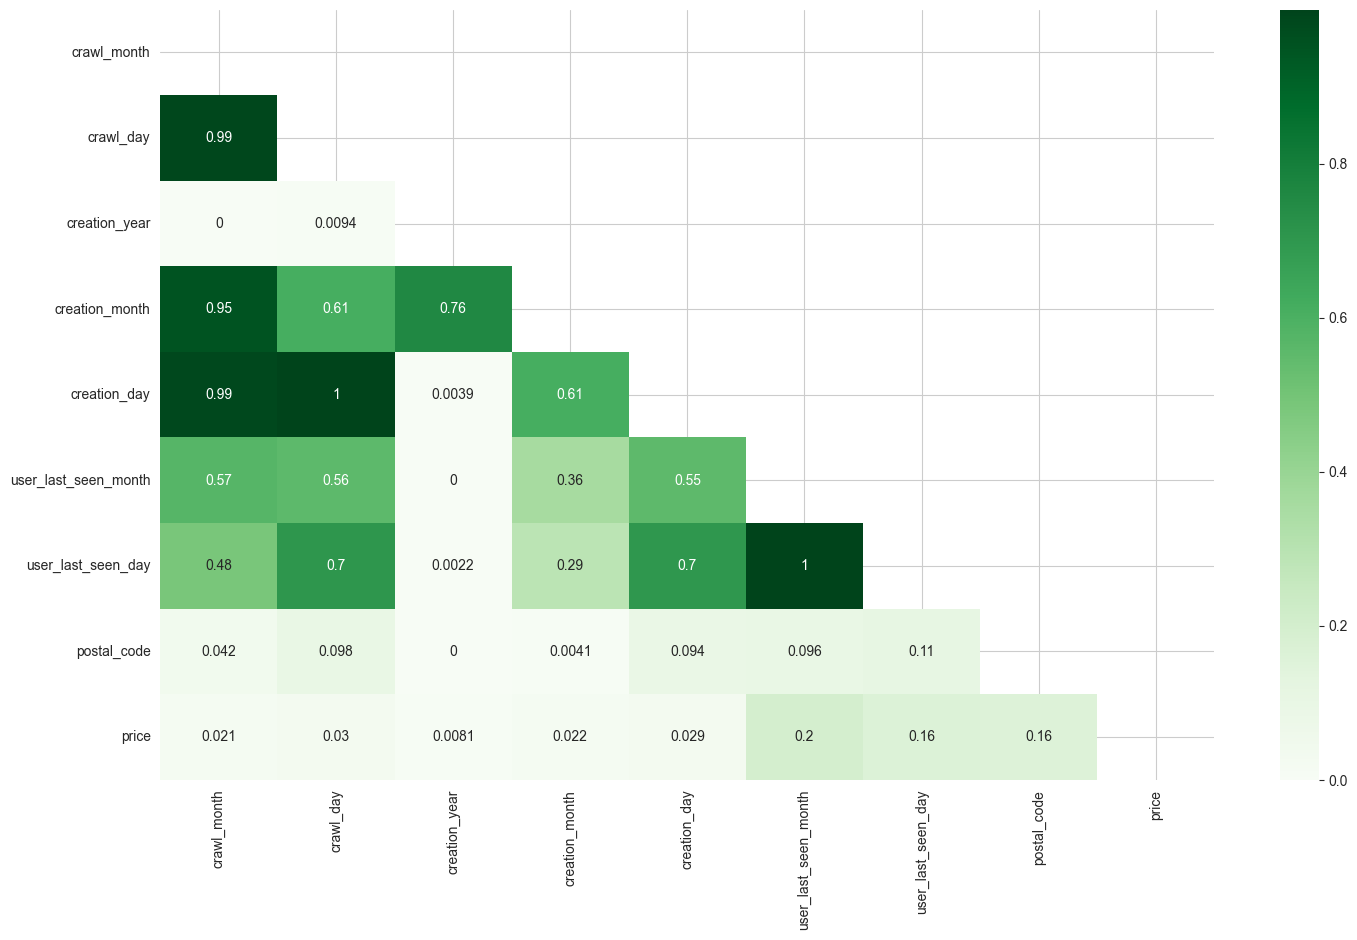

In [8]:
# Проверим, есть ли вообще корреляция в данных столбцах с целевым признаком
temp_df = df[['crawl_year', 'crawl_month', 'crawl_day',
              'creation_year', 'creation_month', 'creation_day',
              'user_last_seen_year', 'user_last_seen_month', 'user_last_seen_day',
              'postal_code', 'price']].copy()

# Устанавливаем пороговое значение
threshold = 500

# Преобразовываем почтовый код в строку и заменяем редкие значения на 'other'
temp_df['postal_code'] = temp_df['postal_code'].astype(str)
postal_code_top = temp_df['postal_code'].value_counts().index[:threshold].tolist()
temp_df.loc[~temp_df['postal_code'].isin(postal_code_top), 'postal_code'] = 'other'

plt.figure(figsize=(17, 10))

# Определяем столбцы с числовыми значениями
ic = ['crawl_year', 'crawl_month', 'crawl_day',
      'creation_year', 'creation_month', 'creation_day',
      'user_last_seen_year', 'user_last_seen_month', 'user_last_seen_day',
      'price']

# Рисуем матрицу корреляции
sns.heatmap(temp_df.phik_matrix(interval_cols=ic),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(temp_df.phik_matrix(interval_cols=ic),
                                      dtype=bool)))

plt.show()

# Удаляем временный датафрейм
del temp_df, postal_code_top, ic

In [9]:
print(df['crawl_year'].unique())
print(df['crawl_month'].unique(), end='\n\n')

print(df['creation_year'].unique())
print(df['creation_month'].unique(), end='\n\n')

print(df['user_last_seen_year'].unique())
print(df['user_last_seen_month'].unique(), end='\n\n')

[2016]
[3 4]

[2016 2015 2014]
[ 3  4  2  1 11 12  9  8  6]

[2016]
[4 3]



Корреляция довольно низкая, а количество значений небольшое. Самая большая корреляция с таргетом у столбца `user_last_seen_month`, но все равно очень маленькая. Удалим все эти столбцы, чтобы не усложнять модель.

In [10]:
# Удаляем столбцы с малой корреляцией
df = df.drop(['crawl_year', 'crawl_month', 'crawl_day',
              'creation_year', 'creation_month', 'creation_day',
              'user_last_seen_year', 'user_last_seen_month', 'user_last_seen_day',
              'postal_code'], axis=1)

# Выводим датафрейм
df

,price,vehicle_type,registration_year,gearbox_type,horsepower,car_model,km_driven,registration_month,fuel_type,car_brand,is_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


### Предобработка неявных дубликатов

Проверим категориальные столбцы на наличие неявных дубликатов

In [11]:
# Выводим уникальные значения в категориальных столбцах
print(df['vehicle_type'].unique(), end='\n\n')
print(df['gearbox_type'].unique(), end='\n\n')
print(df['fuel_type'].unique(), end='\n\n')
print(df['car_brand'].unique(), end='\n\n')
print(df['car_model'].unique(), end='\n\n')

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

['manual' 'auto' nan]

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' '

В столбце `fuel_type` есть 2 одинаковых значения: 'petrol' и 'gasoline'. Это одинаковый вид топлива, различия заключаются только в географии продажи.

В столбце `car_brand` у нас есть тоже 2 похожих значения: 'rover' 'land_rover'. Посмотрим, значения для данных марок.

In [12]:
print(df[df['car_brand'] == 'rover'][['vehicle_type', 'car_brand', 'car_model']].head(10), end='\n\n')
print(df[df['car_brand'] == 'land_rover'][['vehicle_type', 'car_brand', 'car_model']].head(10))

     vehicle_type car_brand  car_model
908         wagon     rover      other
1190        small     rover      other
1328        sedan     rover      other
2334        sedan     rover      other
2787        sedan     rover      other
3323          NaN     rover      other
4850  convertible     rover  discovery
5021        sedan     rover      other
5081        sedan     rover      other
7067        sedan     rover      other

     vehicle_type   car_brand    car_model
2834          suv  land_rover    discovery
2845          NaN  land_rover   freelander
3362          suv  land_rover     defender
4250          suv  land_rover          NaN
4715          suv  land_rover   freelander
5615          suv  land_rover  range_rover
6425        other  land_rover      serie_2
6660        other  land_rover      serie_2
7480          suv  land_rover   freelander
7483          suv  land_rover   freelander


Это все же разные марки, ссылаясь на `vehicle_type`. Оставим все как есть. В конечном итоге неявным дубликатом является только тип топлива. Преобразуем его

In [13]:
# Заменяем значения
df['fuel_type'] = df['fuel_type'].replace({'gasoline': 'petrol'})

# Выводим уникальные значения
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Предобработка явных дубликатов

После того, как мы обработали неявные дубликаты и удалили столбцы с датами, у нас остался "чистый" датасет. Теперь мы можем посмотреть количество явных дубликатов

In [14]:
# Смотрим сколько у нас явных дубликатов
df.duplicated().sum()

np.int64(27693)

In [15]:
# Удаляем дубликаты
df = df.drop_duplicates()

# Проверяем, корректно ли все удалилось
df.duplicated().sum()

np.int64(0)

### Заполнение пропусков

После того как мы удалили все дубликаты, мы можем обработать пропуски

In [16]:
# Выводим количество пропусков по столбцам
df.isna().sum()

price                     0
vehicle_type          35231
registration_year         0
gearbox_type          17567
horsepower                0
car_model             18528
km_driven                 0
registration_month        0
fuel_type             31122
car_brand                 0
is_repaired           66399
dtype: int64

Заполним данные поэтапно. У нас нет пропусков в бренде машины. Сгруппируем их, по фирме машины, заполним пропуски в `car_model` машины модой по сгрупированным данным. Далее уже сгруппировав по модели машины заполним пропуски в `gearbox_type`, `vehicle_type`, `fuel_type`. Столбец `is_repaired` является бинарным. Предположим, что если нет данных о ремонте машине, то ремонта не было, так что заполним пропуски 0, котоый впоследствии будет преобразован в False

In [17]:
def fill_by_group(df: pd.DataFrame, column_to_group: str, column_to_fill: str, value_to_fill: str) -> pd.DataFrame:
    """
    Заполняет пропуски в столбце модой, группируя данные по другому столбцу.

    :param df: Исходный датафрейм.
    :param column_to_group: Столбец, по которому надо сгруппировать данные.
    :param column_to_fill: Столбец, в котором необходимо заполнить пропуски.
    :param value_to_fill: Значение, которым заполняются оставшиеся пропуски.
    :return: Датафрейм с заполненными пропусками.
    """
    df = df.copy()

    # Группируем данные по `column_to_group` и вычисляем моду для каждой группы
    mode_by_group = df.groupby(column_to_group)[column_to_fill].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA
    )

    # Заполняем пропуски в `column_to_fill` с помощью моды по группам
    df[column_to_fill] = df[column_to_fill].fillna(mode_by_group)

    # Заполняем оставшиеся пропуски значением
    df[column_to_fill] = df[column_to_fill].fillna(value_to_fill)

    return df

In [18]:
# Применяем функцию к столбцам
df = fill_by_group(df, 'car_brand', 'car_model', 'unknown')
df = fill_by_group(df, 'car_model', 'gearbox_type', 'unknown')
df = fill_by_group(df, 'car_model', 'vehicle_type', 'unknown')
df = fill_by_group(df, 'car_model', 'fuel_type', 'other')

# Заполняем пропуски в столбце is_repaired и преобразовываем в булевый
df['is_repaired'] = df['is_repaired'].fillna(0).apply(lambda x: True if x == 'yes' else False).astype(bool)

# Выводим количество пропусков
print(df.isna().sum())
df

price                 0
vehicle_type          0
registration_year     0
gearbox_type          0
horsepower            0
car_model             0
km_driven             0
registration_month    0
fuel_type             0
car_brand             0
is_repaired           0
dtype: int64


,price,vehicle_type,registration_year,gearbox_type,horsepower,car_model,km_driven,registration_month,fuel_type,car_brand,is_repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,False
1,18300,coupe,2011,manual,190,a4,125000,5,petrol,audi,True
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,False
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,False
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,False
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,True
354365,2200,sedan,2005,manual,0,unknown,20000,1,petrol,sonstige_autos,False
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,False
354367,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,False


### Обработка выбросов

Посмотрим на выбросы в числовых столбцах и обработаем их

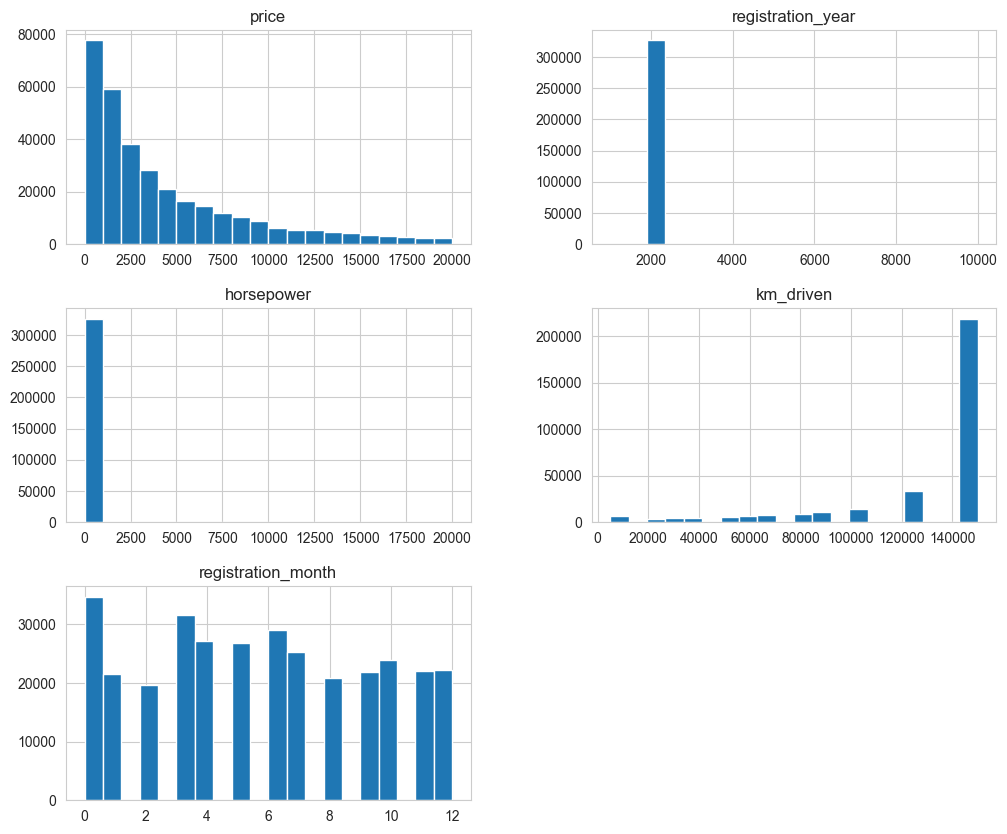

In [19]:
# Выводим гистограммы для числовых столбцов
df.hist(bins=20, figsize=(12, 10))

plt.show()

В принципе все столбцы выглядят правдоподобно, но выбросы в столбцах `horsepower` и `registration_year` помешают данным. Рассмотрим их внимательнее

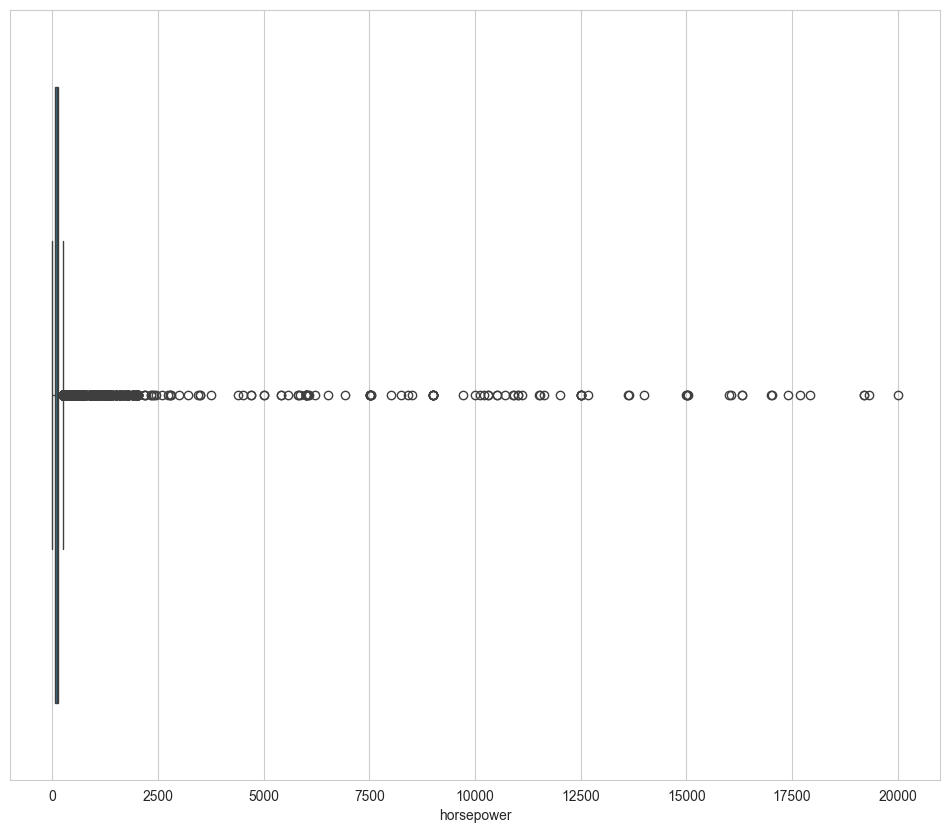

In [20]:
# Выводим диаграмму размаха для мощности машины
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x='horsepower')
plt.show()

In [21]:
# Выводим количество машин с 0 и >600 лошадиных сил
print("Horsepower = 0:", df[df['horsepower'] == 0]['horsepower'].count())
print("Horsepower > 600:", df[df['horsepower'] > 600]['horsepower'].count())
df[df['horsepower'] > 600]

Horsepower = 0: 37013
Horsepower > 600: 377


,price,vehicle_type,registration_year,gearbox_type,horsepower,car_model,km_driven,registration_month,fuel_type,car_brand,is_repaired
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,False
2102,0,sedan,1999,manual,1799,vectra,150000,1,petrol,opel,True
3746,0,small,2017,manual,750,fortwo,150000,8,petrol,smart,False
4060,3100,sedan,2005,manual,953,colt,150000,4,petrol,mitsubishi,False
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,False
...,...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,False
348968,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,True
351947,1500,bus,2001,manual,1001,zafira,5000,7,petrol,opel,False
353493,12500,sedan,2017,manual,2000,other,60000,0,petrol,chrysler,False


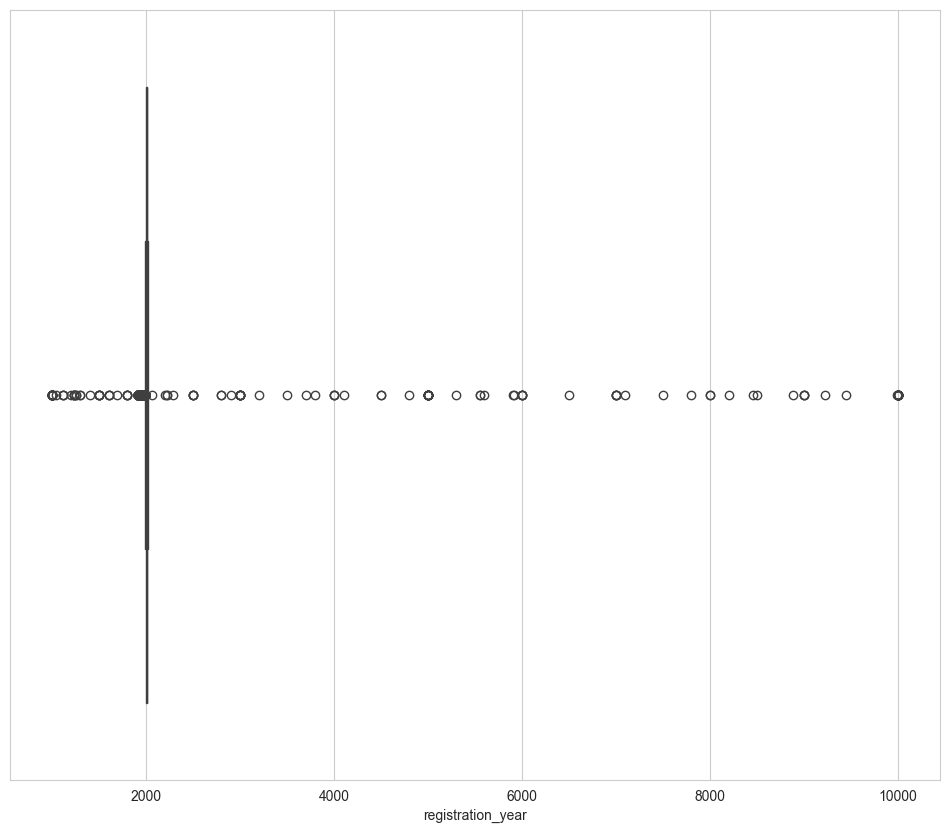

In [22]:
# Выводим диаграмму размаха для года регистрации
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x='registration_year')
plt.show()

In [23]:
# Выводим количество машин с годом регистрации от 1970 до 2025
df.query('~(registration_year >= 1970 and registration_year <= 2025)')['registration_year'].count()

np.int64(1381)

Для столбца `horsepower` определим порог в 600 лошадиных сил, так как это количество уже считается достаточно высоким, а следовательно редким. Выведя несколько значений, чтобы увидеть данные, мы не нашли никаких закономерностей. Таких данных немного (400 записей), так что просто удалим их. Другой проблемой является то, что у нас 37 000 записей, в которых 0 лошадиных сил. Оставим пока что данные как есть. Возможно, впоследствии, заменим нули на пропуски.

Для столбца `registration_year` мы определили диапазон от 1970 до 2025 годов. Нижняя граница обусловлена "реалистичностью" данных. Всего у нас 1400 таких записей, удалим их

In [24]:
# Оставляем записи только с мощностью <= 600
df = df.query('horsepower <= 600')

# Оставляем машины только в диапазоне от 1970 до 2025 года
df = df.query('~(registration_year >= 1970 and registration_year <= 2025)')

# Проверяем, не появилось ли у нас дубликатов
df.duplicated().sum()

np.int64(11)

In [25]:
# Удаляем появившиеся дубликаты
df = df.drop_duplicates()

# Проверяем, остались ли у нас дубликаты
df.duplicated().sum()

np.int64(0)

### Вывод


**Мы удалили следующие столбцы**:
- Столбцы с датами (`crawl_date`, `creation_date`, `user_last_seen`) и производными от них (год, месяц, день), так как корреляционный анализ показал их слабую связь с таргетом.
- Столбец `postal_code` из-за высокой кардинальности (8000 уникальных значений) и отсутствия явной корреляции с ценой.
- Столбец `NumberOfPictures`, содержащий только нули и не несущий полезной информации.

---

**Мы преобразовали неявные дубликаты:**
  - Значения `'gasoline'` и `'petrol'` в столбце `fuel_type` объединены в одно значение `'petrol'`, так как они описывают один тип топлива.
  - Проверены значения `car_brand` и `car_model` (например, `'rover'` и `'land_rover'`), но признаны разными категориями из-за различий в типах кузова и моделей.
- **Заполнение пропусков:**
  - Пропуски в категориальных столбцах (`vehicle_type`, `gearbox_type`, `car_model`, `fuel_type`) заполнены модой, рассчитанной по группам (например, по `car_brand` для `car_model`).
  - Для бинарного признака `is_repaired` пропуски заменены на `False` (отсутствие данных интерпретировано как отсутствие ремонта).

---

**Очистка от дубликатов**
- Мы удалили **28 000 явных дубликатов**

---

**Обработка числовых признаков**
- **Мощность (`horsepower`):**
  - Удалены выбросы (автомобили с мощностью > 600 л.с.), так как такие значения редки и могут быть артефактами (например, ошибки ввода).
- **Год регистрации (`registration_year`):**
  - Удалены записи с годами вне диапазона 1970–2025, чтобы исключить аномалии (например, годы вроде 1000 или 9999).    

## Обучение моделей

## Анализ моделей